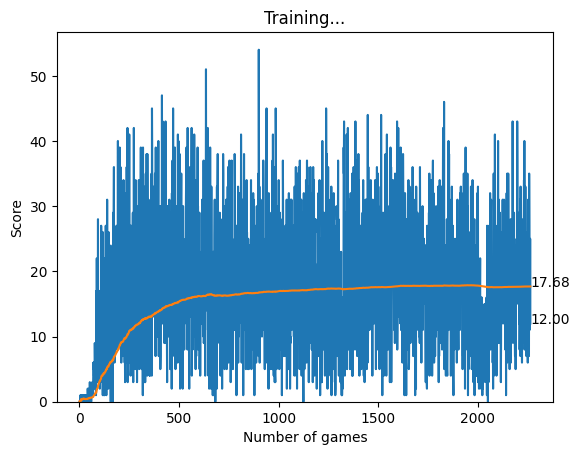

KeyboardInterrupt: 

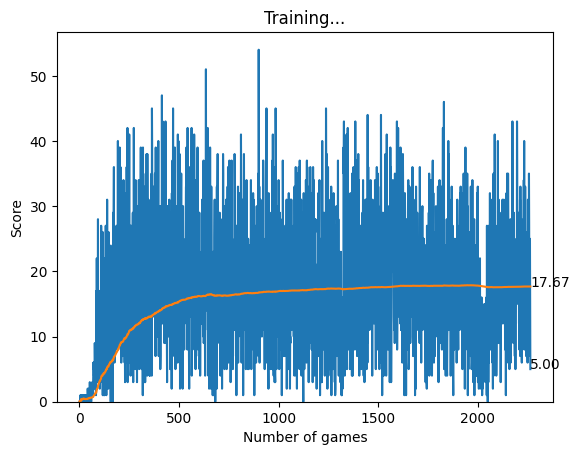

In [1]:
# game
# model

# training : 
#    state, get_state(game)
#    action, get_move(state)
#        model.predict()
#    reward, game_over, score = game.play_step(action)
#    new_state = get_state(game)
#    remember
#    model.train

# imports
import torch
import random
import numpy as np
from collections import deque

# from local files
from game import SnakeGameAI, Direction, Point
from model import Linear_QNet, QTrainer
from helper import plot

# params
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:

    def __init__(self):
        self.n_games = 0
        # randomness with epsilon
        self.epsilon = 0
        # discount factor with gamma, 0 for short term, 1 for long term, smaller than 1
        self.gamma = 0.9
        # memory, pop from left
        self.memory = deque(maxlen=MAX_MEMORY)
        # model
        # can play around with hidden size 256, but 11 and 3 are fixed,
        # 3 is because of 3 directions [straight, left, right]
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)
        # 
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN
        # 
        state = [
            # Danger straight
            (dir_r and game._is_collision(point_r)) or
            (dir_l and game._is_collision(point_l)) or
            (dir_u and game._is_collision(point_u)) or
            (dir_d and game._is_collision(point_d)),
            # Danger right
            (dir_u and game._is_collision(point_r)) or
            (dir_d and game._is_collision(point_l)) or
            (dir_l and game._is_collision(point_u)) or
            (dir_r and game._is_collision(point_d)),
            # Danger left
            (dir_d and game._is_collision(point_r)) or
            (dir_u and game._is_collision(point_l)) or
            (dir_r and game._is_collision(point_u)) or
            (dir_l and game._is_collision(point_d)),
            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            # Food location
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
        ]
        return np.array(state, dtype=int)


    def remember(self, state, action, reward, next_state, game_over):
        self.memory.append((state, action, reward, next_state, game_over))

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, game_overs = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, game_overs)
        # for state, action, reward, next_state, game_over in mini_sample:
        #     self.trainer.train_step(state, action, reward, next_state, game_over)

    def train_short_memory(self, state, action, reward, next_state, game_over):
        self.trainer.train_step(state, action, reward, next_state, game_over)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0, 0, 0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1
        return final_move

def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    # instantiate
    agent = Agent()
    game = SnakeGameAI()
    while True:
        # get old state
        state_old = agent.get_state(game)
        # get move
        final_move = agent.get_action(state_old)
        # perform move and get new state
        reward, game_over, score = game.play_step(final_move)
        state_new = agent.get_state(game)
        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, game_over)
        # remember
        agent.remember(state_old, final_move, reward, state_new, game_over)
        if game_over:
            # train long memory
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()
            if score > record:
                record = score
                agent.model.save()
            
            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)

if __name__ == '__main__':
    train()